### OBJETIVO 01: Obtener un fichero de valoraciones adaptado a nuestro recomendador

1.- La entrada de datos sera el fichero de valoraciones limpio de NULLS, DUPLICADOS, MAPEO DE 'beer_style' de HASTA 2015 a 'beer_advocates_style'DE 2019, resultante del ultimo proceso de datos previo:

     'beer_reviews_v1_1.csv'
     
2.- Estimaremos un threshold de NUMERO DE VALORACIONES x CERVEZA para borrar registros de valoraciones que esten por debajo.

3.- Estimaremos un threshold de NUMERO DE VALORACIONES x USUARIO para borrar registros de valoraciones que esten por debajo.

4.- Finalmente, la salida de datos sera ese NUEVO DATASET DE VALORACIONES que guardaremos en el fichero '.csv':

    'beer_reviews_v2.csv'


### OBJETIVO 02: Obtener un fichero de valoraciones adaptado a nuestro recomendador

Analizaremos los ESTILOS Y CERVEZAS MAS POPULARES Y DE MAYOR CALIDAD en base a sus valoraciones para llegar a conclusiones que ayuden a nuestro recomendador a que sus recomendaciones puedan valer para un espectro de usuarios mas amplio.


In [1]:
# Libreria de Analisis de Datos
import pandas as pd
import numpy as np

# Libreria de Graficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libreria Auxiliar
import itertools

In [2]:
# Leemos el fichero CSV: BEERADVOCATE RATINGS, RESULTANTE DE LA LIMPIEZA Y FILTRADO DEL PROCESO ANTERIOR
reviews_raw = pd.read_csv('./Data/beer_reviews_v1_1.csv', delimiter=',',\
                          dtype={'brewery_name': str, 'review_profilename': str,\
                                 'beer_style': str, 'beer_name': str})

In [3]:
# Haremos una copia para trabajar con ella
dfreviews = reviews_raw.copy()

nRow, nCol = dfreviews.shape
print('Hay',  nRow, 'filas y', nCol, 'columnas')

# Primer vistazo
dfreviews.head()

Hay 1489510 filas y 16 columnas


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,review_average,abv_strength,beer_advocates_style
0,147,Stone Brewing Co.,2006-05-18 09:50:05,4.0,4.5,4.0,zyzygy,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.20,28687,4.3,4,American Barleywine
1,35,Boston Beer Company (Samuel Adams),2006-03-06 20:26:50,4.0,3.5,3.5,zyzygy,English Brown Ale,3.0,3.5,Samuel Adams Brown Ale,5.35,27514,3.5,2,English Brown Ale
2,42,Brewery Ommegang,2006-05-18 07:05:12,4.5,4.5,5.0,zyzygy,Saison Farmhouse Ale,4.5,5.0,Hennepin (Farmhouse Saison),7.70,141,4.7,3,Belgian Saison
3,94,Long Trail Brewing Co.,2006-02-03 23:13:01,4.5,4.0,4.0,zyzygy,Altbier,4.0,4.5,Double Bag,7.20,273,4.2,3,German Altbier
4,33,Berkshire Brewing Company Inc.,2006-03-02 22:44:53,4.0,4.0,3.5,zyzygy,Russian Imperial Stout,3.5,4.5,Berkshire Russian Imperial Stout,8.50,1112,3.9,3,Russian Imperial Stout


In [4]:
# Estructura original del fichero
dfreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489510 entries, 0 to 1489509
Data columns (total 16 columns):
brewery_id              1489510 non-null int64
brewery_name            1489510 non-null object
review_time             1489510 non-null object
review_overall          1489510 non-null float64
review_aroma            1489510 non-null float64
review_appearance       1489510 non-null float64
review_profilename      1489510 non-null object
beer_style              1489510 non-null object
review_palate           1489510 non-null float64
review_taste            1489510 non-null float64
beer_name               1489510 non-null object
beer_abv                1489510 non-null float64
beer_beerid             1489510 non-null int64
review_average          1489510 non-null float64
abv_strength            1489510 non-null int64
beer_advocates_style    1489510 non-null object
dtypes: float64(7), int64(3), object(6)
memory usage: 181.8+ MB


In [5]:
# Los PARAMETROS DE VALORACION DE CERVEZAS AHORA SI TIENEN SU PUNTUACION ENTRE 1 Y 5, CADA UNO
# beer_abv tiene MINIMO MENOR QUE 0 SIGUE SIENDO INVALIDO: TODAVIA NO SE SI LO USAREMOS, LO DEJAMOS ASI
dfreviews.describe()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,review_average,abv_strength
count,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06,1.489510e+06
mean,3.071700e+03,3.822860e+00,3.743388e+00,3.847745e+00,3.751183e+00,3.801813e+00,7.041184e+00,2.145860e+04,3.793398e+00,2.805335e+00
std,5.543628e+03,7.118135e-01,6.889830e-01,6.072120e-01,6.727253e-01,7.229868e-01,2.319915e+00,2.180543e+04,5.712579e-01,7.839940e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00,1.100000e+00,1.000000e+00
25%,1.410000e+02,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.655000e+03,3.500000e+00,2.000000e+00
50%,4.150000e+02,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.299300e+04,3.900000e+00,3.000000e+00
75%,2.295000e+03,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.929600e+04,4.200000e+00,3.000000e+00
max,2.800300e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04,4.900000e+00,4.000000e+00


## HAREMOS UN ANALISIS DE LAS VALORACIONES PARA AJUSTAR EL RECOMENDADOR

#### QUITAREMOS LAS COLUMNAS INNECESARIAS

In [6]:
dfreviews = dfreviews.drop(["brewery_id"], axis=1)
dfreviews = dfreviews.drop(["review_time"], axis=1)
dfreviews = dfreviews.drop(["beer_beerid"], axis=1)
dfreviews.head()

,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style
0,Stone Brewing Co.,4.0,4.5,4.0,zyzygy,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.20,4.3,4,American Barleywine
1,Boston Beer Company (Samuel Adams),4.0,3.5,3.5,zyzygy,English Brown Ale,3.0,3.5,Samuel Adams Brown Ale,5.35,3.5,2,English Brown Ale
2,Brewery Ommegang,4.5,4.5,5.0,zyzygy,Saison Farmhouse Ale,4.5,5.0,Hennepin (Farmhouse Saison),7.70,4.7,3,Belgian Saison
3,Long Trail Brewing Co.,4.5,4.0,4.0,zyzygy,Altbier,4.0,4.5,Double Bag,7.20,4.2,3,German Altbier
4,Berkshire Brewing Company Inc.,4.0,4.0,3.5,zyzygy,Russian Imperial Stout,3.5,4.5,Berkshire Russian Imperial Stout,8.50,3.9,3,Russian Imperial Stout


In [7]:
# Los valores STRING se cargan con el TIPO PANDAS object: Convertiremos 'object' a Tipos PANDAS 'category'
# Asi los STRINGS se codificaran como numeros y sera mas eficiente su analisis posterior
dfreviews[dfreviews.select_dtypes(['object']).columns] = \
    dfreviews.select_dtypes(['object']).apply(lambda x: x.astype('category'))

dfreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489510 entries, 0 to 1489509
Data columns (total 13 columns):
brewery_name            1489510 non-null category
review_overall          1489510 non-null float64
review_aroma            1489510 non-null float64
review_appearance       1489510 non-null float64
review_profilename      1489510 non-null category
beer_style              1489510 non-null category
review_palate           1489510 non-null float64
review_taste            1489510 non-null float64
beer_name               1489510 non-null category
beer_abv                1489510 non-null float64
review_average          1489510 non-null float64
abv_strength            1489510 non-null int64
beer_advocates_style    1489510 non-null category
dtypes: category(5), float64(7), int64(1)
memory usage: 108.4 MB


## BUSCAREMOS EL UMBRAL DE NUMERO DE VALORACIONES MINIMO POR USUARIO

En principio, un usuario con una sola valoracion de una sola cerveza no sera adecuado como datos de entrada para nuestro recomendador: necesitamos averiguar cual es el minimo de valoraciones por usuario para que, al mismo tiempo, sigamos teniendo un numero total de valoraciones adecuado y un numero total de usuarios adecuado.

In [9]:
# Tenemos valoraciones para 44041 CERVEZAS
totalRatedBeers = len(dfreviews.beer_name.unique())
totalRatedBeers

44041

In [10]:
# Tenemos 32389 USUARIOS DISTINTOS que han hecho valoraciones al menos 1 VALORACION DE 1 CERVEZA
totalRatingUsers = len(dfreviews.review_profilename.unique())
totalRatingUsers

32389

#### 'review_average'

Usaremos la COLUMNA AÑADIDA 'review_average' que es LA MEDIA DE TODOS LOS PARAMETROS DE VALORACION DE LAS CERVEZAS.

Al mismo tiempo tambien nos valdra como una MEDIDA DE LA CALIDAD DE LA CERVEZA.

Usando 'review_average' echaremos un vistazo a la distribucion de valoraciones por usuario

In [11]:
ratesPerUser = dfreviews[['review_profilename', 'review_average']].groupby(['review_profilename'], as_index = False) \
                .count() \
                .rename(columns = {'review_average' : 'totalUserRatings'}) \
                .sort_values('totalUserRatings', ascending = False)

ratesPerUser.head(10)

,review_profilename,totalUserRatings
26121,northyorksammy,5177
2276,BuckeyeNation,4141
24934,mikesgroove,4121
12036,Thorpe429,3228
31932,womencantsail,3112
2670,ChainGangGuy,3091
9416,Phyl21ca,3064
15588,brentk56,3062
8687,NeroFiddled,3015
26245,oberon,2834


In [12]:
ratesPerUser.describe()

,totalUserRatings
count,32389.000000
mean,45.988144
std,169.476477
min,1.000000
25%,1.000000
50%,3.000000
75%,17.000000
max,5177.000000


EL 75% DE LOS USUARIOS TIENEN 17 VALORACIONES.
LA MEDIA DE VALORACIONES DE DISTINTAS CERVEZAS POR CADA USUARIO ES 45 CON UNA ALTA DESVIACION ESTANDAR DE 170.
EL HISTOGRAMA ESTA ORIENTADO A LA IZQUIERDA SEGURAMENTE POR LOS USUARIOS MAS ANTIGUOS Y QUE MAS VECES VALORAN.

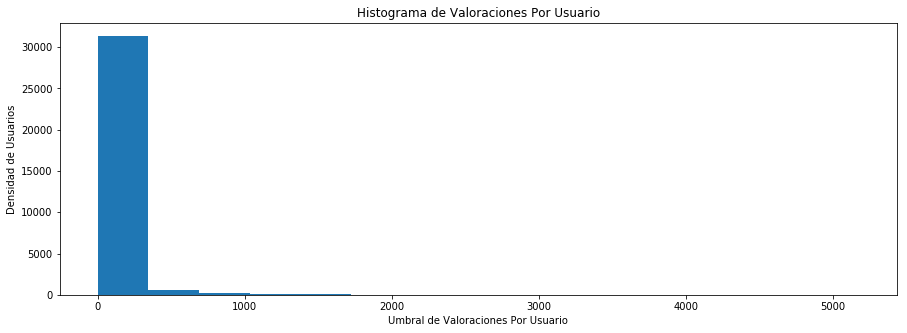

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.hist(ratesPerUser['totalUserRatings'], bins = 15)
plt.xlabel('Umbral de Valoraciones Por Usuario')
plt.ylabel('Densidad de Usuarios')
plt.title('Histograma de Valoraciones Por Usuario')
plt.show()

Haremos ZOOM sobre la zona que tiene la mayoria de los de Usuarios que valoran

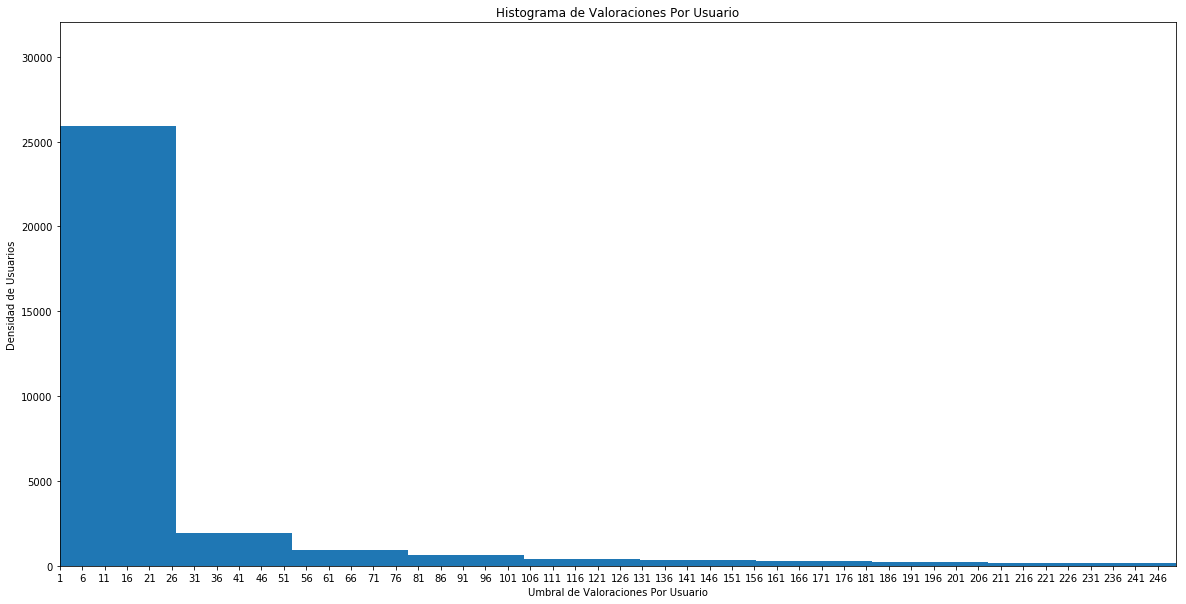

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.hist(ratesPerUser['totalUserRatings'], bins = 200)
plt.xlabel('Umbral de Valoraciones Por Usuario')
plt.ylabel('Densidad de Usuarios')
plt.xlim(1, 250)
plt.ylim(1, 32040)
plt.title('Histograma de Valoraciones Por Usuario')
plt.xticks(np.arange(1, (250+1), 5))
plt.show()

Como la mayoria de los usuarios han hecho entre 1 y 30 valoraciones, parece que un umbral de 30 seria un buen valor para mantener un buen numero de usuarios y tener bastantes valoraciones por usuario para poder recomendar mejor. No obstante, lo estudiaremos mas en detalle a continuacion.

In [14]:
def userRatingsThresholdImpact(groupedRates, threshold = 1):
    # Numero Total de Usuarios Que Han Valorado <= threshold CERVEZAS
    totalThresholdUsers = groupedRates[groupedRates['totalUserRatings'] <= threshold]['totalUserRatings'].count()
    # Numero Total de Valoraciones de los Usuarios Que Han Valorado <= threshold CERVEZAS
    totalThresholdRatings = groupedRates[groupedRates['totalUserRatings'] <= threshold]['totalUserRatings'].sum()
    print(threshold, '\t\t', totalThresholdUsers, '\t', totalThresholdRatings, \
          round((totalThresholdUsers * 100) / totalRatingUsers, 4), "%", \
          round((totalThresholdRatings * 100) / nRow, 4), "%" ) #, \
#          round((((totalRatingUsers - totalThresholdUsers) * 100) / totalRatingUsers), 4), "%", '\t', \
#          round((((nRow - totalThresholdRatings) * 100) / nRow), 4), "%\n")

In [15]:
print('threshold\t', 'totalUsers', 'totalRatings', 'usersPct', 'ratingsPct\n')
for threshold in [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1]:
    userRatingsThresholdImpact(ratesPerUser, threshold)

threshold	 totalUsers totalRatings usersPct ratingsPct

50 		 27757 	 189019 85.6988 % 12.69 %
45 		 27484 	 175938 84.856 % 11.8118 %
40 		 27211 	 164261 84.0131 % 11.0279 %
35 		 26852 	 150666 82.9047 % 10.1151 %
30 		 26368 	 134721 81.4104 % 9.0447 %
25 		 25810 	 119191 79.6875 % 8.002 %
20 		 25036 	 101586 77.2978 % 6.8201 %
15 		 23993 	 82980 74.0776 % 5.571 %
10 		 22396 	 62550 69.1469 % 4.1994 %
5 		 19114 	 37296 59.0139 % 2.5039 %
1 		 10031 	 10031 30.9704 % 0.6734 %


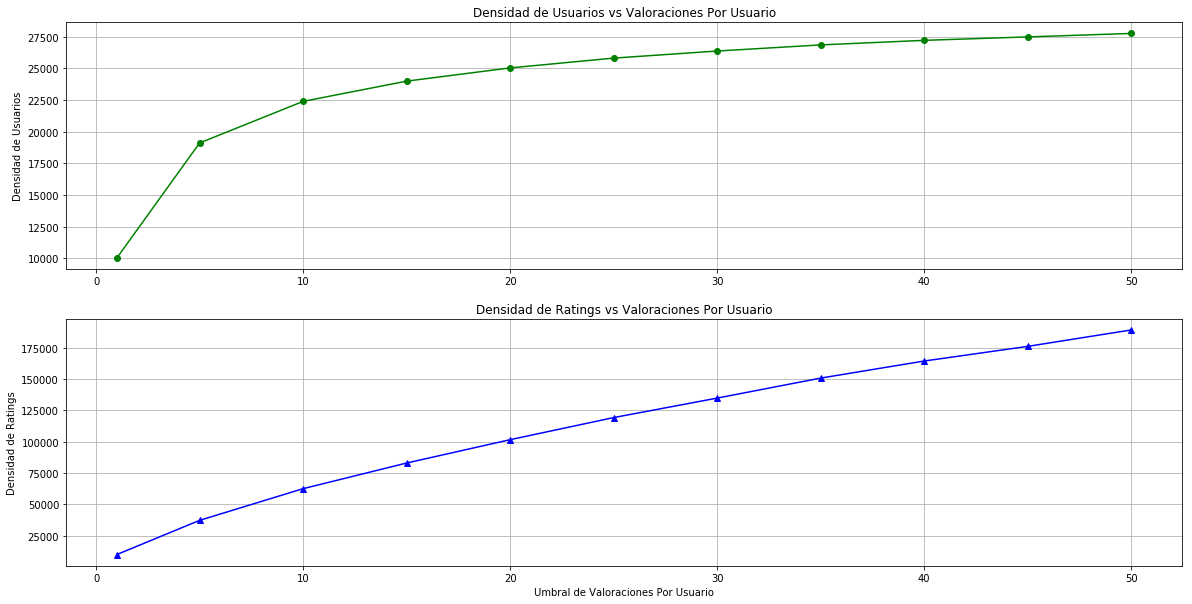

In [16]:
figure, (subplot1, subplot2) = plt.subplots(2)

subplot1.set(ylabel='Densidad de Usuarios')
subplot2.set(xlabel='Umbral de Valoraciones Por Usuario', ylabel='Densidad de Ratings')
    
subplot1.set_title('Densidad de Usuarios vs Valoraciones Por Usuario')
subplot2.set_title('Densidad de Ratings vs Valoraciones Por Usuario')

subplot1.grid(True)
subplot2.grid(True)

def userRatingsThresholdGraphics(groupedRates):
    x = []
    y1 = []
    y2 = []
    for threshold in  [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1]:
        # Numero Total de Usuarios Que Han Valorado <= threshold CERVEZAS
        totalThresholdUsers = groupedRates[groupedRates['totalUserRatings'] <= threshold]['totalUserRatings'].count()
        # Numero Total de Valoraciones de los Usuarios Que Han Valorado <= threshold CERVEZAS
        totalThresholdRatings = groupedRates[groupedRates['totalUserRatings'] <= threshold]['totalUserRatings'].sum()
        x.append(threshold)
        y1.append(totalThresholdUsers)
        y2.append(totalThresholdRatings)
        
    subplot1.plot(x, y1, 'go-', label='Total Threshold Users')
    subplot2.plot(x, y2, 'b^-', label= 'Total Threshold Ratings')

userRatingsThresholdGraphics(ratesPerUser)

En base al análisis, tendriamos que quedarnos con un umbral de entre 20 y 30 valoraciones por cerveza, dependiendo de cómo afecte al numero total valoraciones de cervezas que nos queden.

##### REFERENCIA: "Practical Recommender Systems" de Kim Falk de la edición de 2019 (Editorial Manning)

Este libro comenta que un numero de 20 valoraciones por usuario suele funcionar bien para la mayoria de las e-shop.

##### FINALEMENTE ELEGIREMOS 30 valoraciones por usuario COMO MINIMO.

A continuacion filtraremos los usuarios con menos de 30 valoraciones.

In [17]:
dfreviewsAux = pd.merge(dfreviews, ratesPerUser, on = ['review_profilename'])
dfreviewsAux.head()

,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalUserRatings
0,Stone Brewing Co.,4.0,4.5,4.0,zyzygy,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.20,4.3,4,American Barleywine,5
1,Boston Beer Company (Samuel Adams),4.0,3.5,3.5,zyzygy,English Brown Ale,3.0,3.5,Samuel Adams Brown Ale,5.35,3.5,2,English Brown Ale,5
2,Brewery Ommegang,4.5,4.5,5.0,zyzygy,Saison Farmhouse Ale,4.5,5.0,Hennepin (Farmhouse Saison),7.70,4.7,3,Belgian Saison,5
3,Long Trail Brewing Co.,4.5,4.0,4.0,zyzygy,Altbier,4.0,4.5,Double Bag,7.20,4.2,3,German Altbier,5
4,Berkshire Brewing Company Inc.,4.0,4.0,3.5,zyzygy,Russian Imperial Stout,3.5,4.5,Berkshire Russian Imperial Stout,8.50,3.9,3,Russian Imperial Stout,5


In [18]:
# TENGO 1489510 REGISTROS DE VALORACIONES
print(len(dfreviewsAux))
dfreviewsAux.sort_values('totalUserRatings', ascending = False).head(10)

1489510


,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalUserRatings
277215,New Glarus Brewing Company,4.0,4.0,4.0,northyorksammy,Oatmeal Stout,4.0,3.5,Road Slush Stout,6.2,3.9,3,English Oatmeal Stout,5177
280194,Rowland's Calumet Brewery,3.0,3.5,4.0,northyorksammy,Schwarzbier,3.0,3.5,Calumet Total Eclipse,5.0,3.4,2,German Schwarzbier,5177
280218,Butte Creek Brewing Company,3.5,4.0,4.0,northyorksammy,American Porter,3.0,3.5,Butte Creek Organic Porter,6.1,3.6,3,American Porter,5177
280217,Butte Creek Brewing Company,4.0,4.0,3.5,northyorksammy,American Double Imperial IPA,3.5,3.5,Butte Creek Organic Revolution X Imperial IPA,9.1,3.7,4,American Imperial IPA,5177
280216,Cool Beer Brewing Co.,4.0,3.5,3.5,northyorksammy,Herbed Spiced Beer,3.0,3.5,Buzz Twisted,4.8,3.5,2,Herb and Spice Beer,5177
280215,Paddock Wood Brewing Co.,3.5,4.0,4.0,northyorksammy,Oatmeal Stout,3.5,3.5,Bête Noire,5.4,3.7,2,English Oatmeal Stout,5177
280214,Grand River Brewing,3.5,3.0,3.0,northyorksammy,American Pale Wheat Ale,3.0,3.5,C'est Wheat,5.1,3.2,2,American Pale Wheat Ale,5177
280213,CB's Brewing Company,4.0,4.0,4.0,northyorksammy,Witbier,4.0,4.0,CB's Barry,6.5,4.0,3,Belgian Witbier,5177
280212,CB's Brewing Company,4.0,4.0,4.0,northyorksammy,American IPA,3.5,3.5,CB's Caged Alpha Monkey IPA,6.5,3.8,3,American IPA,5177
280211,CB's Brewing Company,4.0,3.5,4.0,northyorksammy,American Porter,4.0,4.0,CB's Double Dark Cream Porter,5.0,3.9,2,American Porter,5177


In [19]:
# MANTENDREMOS LOS USUARIOS QUE TENGAN >= 30 VALORACIONES
# Expresion Logica de WISE OPERATION: MARCAMOS REGISTROS DE USUARIOS CON MENOR O IGUAL A 30 VALORACIONES
minimumRatingsExpr = dfreviewsAux.totalUserRatings < 30
minimumRatingsExpr.head()

0    True
1    True
2    True
3    True
4    True
Name: totalUserRatings, dtype: bool

In [20]:
# FILTRAREMOS 132111 REGISTROS DE VALORACIONES DE LOS USUARIOS CON MENOR O IGUAL A 30 VALORACIONES
np.sum(minimumRatingsExpr)

132111

In [21]:
# ME HAN QUEDADO 1489510 - 132111 = 1357399 REGISTROS DE VALORACIONES
dfreviewsAux = dfreviewsAux[-minimumRatingsExpr]
len(dfreviewsAux)
#dfreviewsAux.shape[0]

1357399

In [22]:
# NOS HAN QUEDADO 6108 USUARIOS EN TOTAL
len(dfreviewsAux.review_profilename.unique())

6108

## BUSCAREMOS EL UMBRAL DE NUMERO DE VALORACIONES MINIMO POR CERVEZA

En principio, una cerveza con una sola valoracion no sera adecuado como datos de entrada para nuestro recomendador: necesitamos averiguar cual es el minimo de valoraciones por cerveza para que, al mismo tiempo, sigamos teniendo un numero total de valoraciones adecuado y un numero total de cervezas adecuado.

In [23]:
# NOS HAN QUEDADO 43807 CERVEZAS EN TOTAL DE UN TOTAL DE 44041: NO HAN BAJADO MUCHO
len(dfreviewsAux.beer_name.unique())

43807

In [24]:
ratesPerBeer = dfreviewsAux[['beer_name', 'review_average']].groupby(['beer_name'], as_index = False) \
                .count() \
                .rename(columns = {'review_average' : 'totalBeerRatings'}) \
                .sort_values('totalBeerRatings', ascending = False)

ratesPerBeer.tail()

,beer_name,totalBeerRatings
35519,Silver Key Light,0
34528,Schloss Pils,0
40438,Tsar,0
8028,Caesar Rodney Golden Ale,0
4519,Bier Du Cerise,0


In [25]:
ratesPerBeer.head(10)

,beer_name,totalBeerRatings
705,90 Minute IPA,2513
35427,Sierra Nevada Celebration Ale,2459
28552,Old Rasputin Russian Imperial Stout,2430
37595,Stone Ruination IPA,2187
40660,Two Hearted Ale,2158
2482,Arrogant Bastard Ale,2141
35421,Sierra Nevada Bigfoot Barleywine Style Ale,2108
37555,Stone IPA (India Pale Ale),2107
7265,Brooklyn Black Chocolate Stout,2062
610,60 Minute IPA,2035


Se observa que hay cervezas con muy pocas o ninguna valoracion.
Las cervezas con 0 valoraciones no nos interesan como entrada para el recomendador porque no produciran buenas recomendaciones.

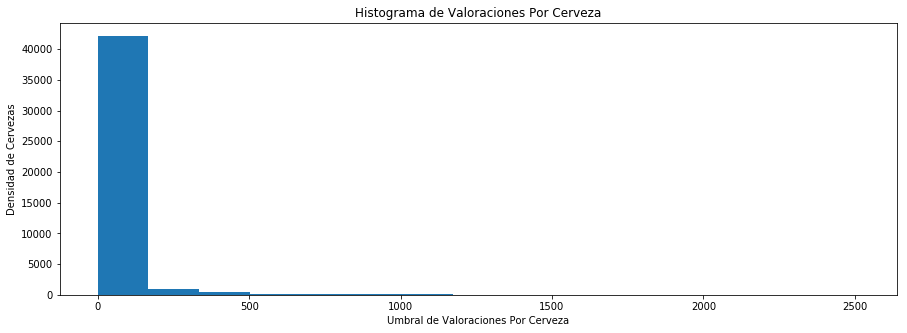

In [26]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.xlabel('Umbral de Valoraciones Por Cerveza')
plt.ylabel('Densidad de Cervezas')
plt.title('Histograma de Valoraciones Por Cerveza')
plt.hist(ratesPerBeer['totalBeerRatings'], bins = 15)
plt.show()

EL 75% DE LAS CERVEZAS TIENEN 11 VALORACIONES.
LA MEDIA DE VALORACIONES PARA CADA CERVEZA ES 31 CON UNA ALTA DESVIACION ESTANDAR DE 117.
EL HISTOGRAMA ESA ORIENTADO A LA IZQUIERDA SEGURAMENTE POR LAS CERVEZAS MAS POPULARES.

In [27]:
ratesPerBeer.describe()

,totalBeerRatings
count,44041.000000
mean,30.821257
std,116.704367
min,0.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,2513.000000


Haremos ZOOM sobre la zona que tiene las Cervezas que mas veces se han valorado

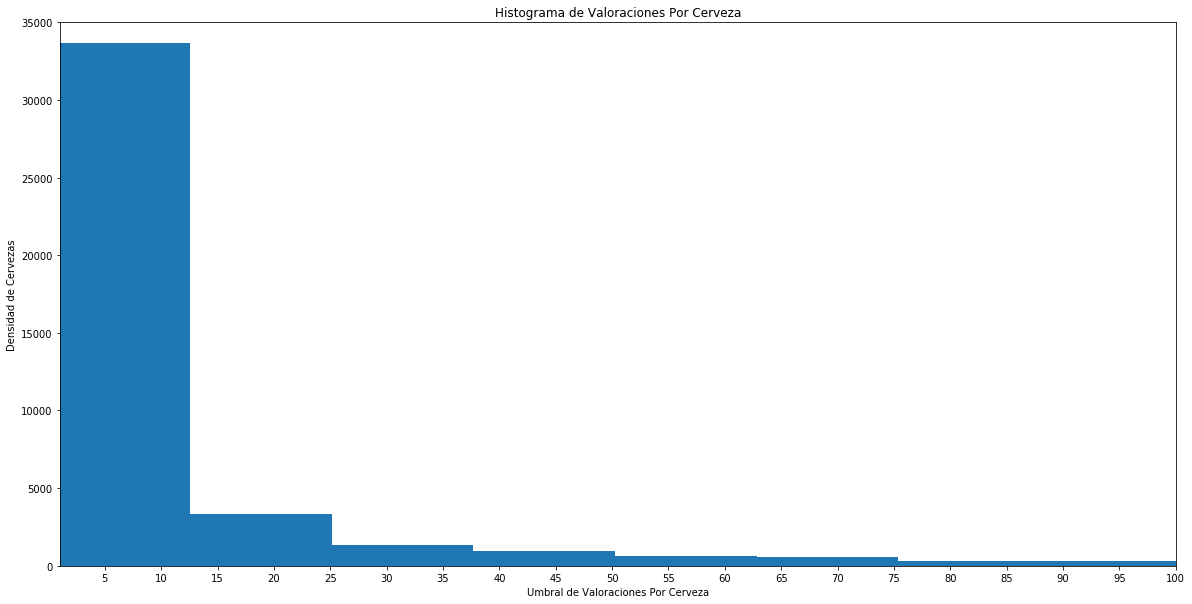

In [28]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel('Umbral de Valoraciones Por Cerveza')
plt.ylabel('Densidad de Cervezas')
plt.title('Histograma de Valoraciones Por Cerveza')
plt.hist(ratesPerBeer['totalBeerRatings'], bins = 200)
plt.xticks(np.arange(0, (100 + 1), 5.0))
plt.xlim(1, 100)
plt.ylim(1, 35000)
plt.show()

Como la mayoria de los cervezas han sido valoradas entre 1 y 25 veces, parece que un umbral de 25 seria un buen valor para mantener un buen numero de cervezas y tener bastantes valoraciones por cerveza para poder recomendar mejor. No obstante, lo estudiaremos mas en detalle a continuacion.

In [29]:
def beerRatingsThresholdImpact(groupedRates, threshold = 1):
    # Numero Total de Cervezas Que Han Sido Valoradas <= threshold Veces
    totalThresholdBeers = groupedRates[groupedRates['totalBeerRatings'] <= threshold]['totalBeerRatings'].count()
    # Numero Total de Valoraciones de Cervezas Que Han Sido Valoradas <= threshold Veces
    totalThresholdBeerRatings = groupedRates[groupedRates['totalBeerRatings'] <= threshold]['totalBeerRatings'].sum()
    print(threshold, '\t\t', totalThresholdBeers, '\t\t', totalThresholdBeerRatings, '\t', \
          round((totalThresholdBeers * 100) / totalRatedBeers, 4), "%", \
          round((totalThresholdBeerRatings  * 100) / nRow, 4), "%" )

In [30]:
print('threshold\t', 'totalBeers\t', 'totalBeerRating', 'beersPct', 'beerRatingsPct\n')
for threshold in range(1, 50, 5):  #[50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1, 0]:
    beerRatingsThresholdImpact(ratesPerBeer, threshold)

threshold	 totalBeers	 totalBeerRating beersPct beerRatingsPct

1 		 14040 		 13806 	 31.8794 % 0.9269 %
6 		 29433 		 63457 	 66.8309 % 4.2603 %
11 		 33181 		 95761 	 75.3412 % 6.429 %
16 		 35103 		 122251 	 79.7053 % 8.2075 %
21 		 36250 		 143801 	 82.3097 % 9.6542 %
26 		 37151 		 165293 	 84.3555 % 11.0971 %
31 		 37776 		 183384 	 85.7746 % 12.3117 %
36 		 38288 		 200760 	 86.9372 % 13.4783 %
41 		 38731 		 218011 	 87.9431 % 14.6364 %
46 		 39093 		 233897 	 88.765 % 15.7029 %


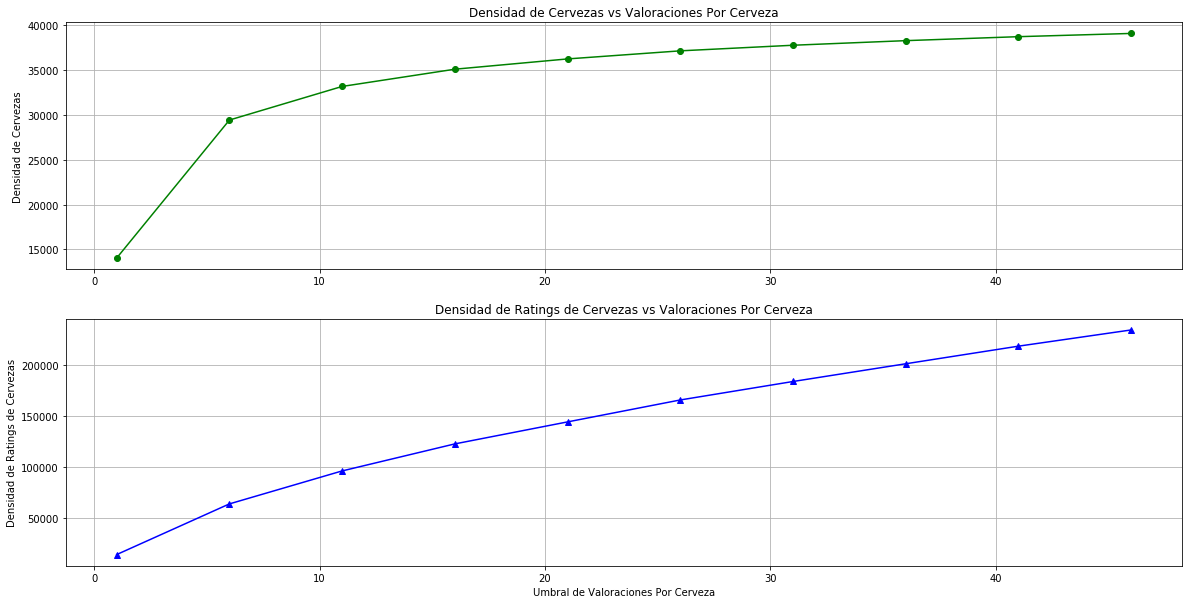

In [31]:
figure, (subplot1, subplot2) = plt.subplots(2)

subplot1.set(ylabel='Densidad de Cervezas')
subplot2.set(xlabel='Umbral de Valoraciones Por Cerveza', ylabel='Densidad de Ratings de Cervezas')
    
subplot1.set_title('Densidad de Cervezas vs Valoraciones Por Cerveza')
subplot2.set_title('Densidad de Ratings de Cervezas vs Valoraciones Por Cerveza')

subplot1.grid(True)
subplot2.grid(True)

def beerRatingsThresholdGraphics(groupedRates):
    x = []
    y1 = []
    y2 = []
    for threshold in range(1, 50, 5):
        # Numero Total de Cervezas Que Han Sido Valoradas <= threshold Veces
        totalThresholdBeers = groupedRates[groupedRates['totalBeerRatings'] <= threshold]['totalBeerRatings'].count()
        # Numero Total de Valoraciones de Cervezas Que Han Sido Valoradas <= threshold Veces
        totalThresholdBeerRatings = groupedRates[groupedRates['totalBeerRatings'] <= threshold]['totalBeerRatings'].sum()
        x.append(threshold)
        y1.append(totalThresholdBeers)
        y2.append(totalThresholdBeerRatings)
        
    subplot1.plot(x, y1, 'go-', label='Total Threshold Beers')
    subplot2.plot(x, y2, 'b^-', label='Total Threshold Beer Ratings')

beerRatingsThresholdGraphics(ratesPerBeer)

En base al análisis, tendriamos que quedarnos con un umbral de entre 25 y 30 valoraciones por cerveza, dependiendo de cómo afecte al numero total valoraciones de cervezas que nos queden.

##### FINALMENTE ELEGIREMOS 30 valoraciones por cerveza COMO MINIMO.

A continuacion filtraremos las cervezas qie han sido valoradas menos de 30 veces.

In [32]:
dfreviewsAux = pd.merge(dfreviews, ratesPerBeer, on = ['beer_name'])
dfreviewsAux.head()

,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalBeerRatings
0,Stone Brewing Co.,4.0,4.5,4.0,zyzygy,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.2,4.3,4,American Barleywine,159
1,Stone Brewing Co.,4.5,4.0,3.0,ypsifly,American Barleywine,4.0,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.2,4.0,4,American Barleywine,159
2,Stone Brewing Co.,4.0,4.5,4.0,woemad,American Barleywine,4.5,4.5,Stone Old Guardian Barley Wine Style Ale 2006,11.2,4.3,4,American Barleywine,159
3,Stone Brewing Co.,4.0,4.0,4.5,wnhay,American Barleywine,4.0,4.0,Stone Old Guardian Barley Wine Style Ale 2006,11.2,4.1,4,American Barleywine,159
4,Stone Brewing Co.,3.0,3.0,4.5,williamherbert,American Barleywine,3.0,3.5,Stone Old Guardian Barley Wine Style Ale 2006,11.2,3.4,4,American Barleywine,159


In [33]:
# TENGO 1489510 REGISTROS DE VALORACIONES
print(len(dfreviewsAux))
dfreviewsAux.sort_values('totalBeerRatings', ascending = False).head()

1489510


,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalBeerRatings
177155,Dogfish Head Brewery,4.0,4.5,4.0,trbergman,American Double Imperial IPA,4.0,5.0,90 Minute IPA,9.0,4.3,4,American Imperial IPA,2513
178084,Dogfish Head Brewery,4.5,4.0,3.5,hustlemuscle,American Double Imperial IPA,4.5,4.5,90 Minute IPA,9.0,4.2,4,American Imperial IPA,2513
178082,Dogfish Head Brewery,3.5,4.0,4.5,hyland24,American Double Imperial IPA,4.0,4.0,90 Minute IPA,9.0,4.0,4,American Imperial IPA,2513
178081,Dogfish Head Brewery,4.5,4.5,4.5,hyuga,American Double Imperial IPA,4.5,4.5,90 Minute IPA,9.0,4.5,4,American Imperial IPA,2513
178080,Dogfish Head Brewery,4.0,4.5,4.5,iAmOverrated,American Double Imperial IPA,4.0,4.5,90 Minute IPA,9.0,4.3,4,American Imperial IPA,2513


In [34]:
# MANTENDREMOS LAS CERVEZAS QUE TENGAN >= 30 VALORACIONES
# Expresion Logica de WISE OPERATION: MARCAMOS REGISTROS DE USUARIOS CON MENOR O IGUAL A 30 VALORACIONES
minimumRatingsExpr = dfreviewsAux.totalBeerRatings < 30
minimumRatingsExpr.head()

0    False
1    False
2    False
3    False
4    False
Name: totalBeerRatings, dtype: bool

In [35]:
# FILTRAREMOS 188337 REGISTROS DE VALORACIONES DE CERVEZAS CON MENOR O IGUAL A 30 VALORACIONES
np.sum(minimumRatingsExpr)

188337

In [36]:
# ME HAN QUEDADO 1489510 - 188337 = 1301173 REGISTROS DE VALORACIONES
dfreviewsAux = dfreviewsAux[-minimumRatingsExpr]
len(dfreviewsAux)

1301173

In [37]:
dfreviewsAux.shape

(1301173, 14)

In [38]:
dfreviewsAux.describe()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,review_average,abv_strength,totalBeerRatings
count,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06,1.301173e+06
mean,3.844765e+00,3.767165e+00,3.868639e+00,3.773944e+00,3.828190e+00,7.134884e+00,3.816540e+00,2.837179e+00,5.571084e+02
std,7.017427e-01,6.829077e-01,6.024430e-01,6.649581e-01,7.144168e-01,2.332543e+00,5.620543e-01,7.831486e-01,5.262809e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e-01,1.100000e+00,1.000000e+00,3.000000e+01
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.300000e+00,3.500000e+00,2.000000e+00,1.550000e+02
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.600000e+00,3.900000e+00,3.000000e+00,3.690000e+02
75%,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,4.200000e+00,3.000000e+00,8.000000e+02
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,4.100000e+01,4.900000e+00,4.000000e+00,2.513000e+03


In [39]:
dfreviewsAux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301173 entries, 0 to 1454198
Data columns (total 14 columns):
brewery_name            1301173 non-null category
review_overall          1301173 non-null float64
review_aroma            1301173 non-null float64
review_appearance       1301173 non-null float64
review_profilename      1301173 non-null category
beer_style              1301173 non-null category
review_palate           1301173 non-null float64
review_taste            1301173 non-null float64
beer_name               1301173 non-null category
beer_abv                1301173 non-null float64
review_average          1301173 non-null float64
abv_strength            1301173 non-null int64
beer_advocates_style    1301173 non-null category
totalBeerRatings        1301173 non-null int64
dtypes: category(5), float64(7), int64(2)
memory usage: 115.0 MB


## GUARDAREMOS ESTE NUEVO DATASET PARA EL SIGUIENTE PASO DE ANALISIS

In [41]:
# Almacenaremos el NUEVO DATASET CON LAS VALORACIONES UTILES COMO ENTRADA DEL SIGUIENTE PROCESO DE ANALISIS
dfreviewsAux[['brewery_name','beer_name','beer_style', 'beer_advocates_style', 'beer_abv',\
              'review_profilename',\
              'review_overall','review_aroma','review_appearance','review_palate','review_taste',\
              'review_average','abv_strength']].to_csv('./Data/beer_reviews_v2.csv', sep=',', index=False)

### ANALIZAREMOS LOS ESTILOS Y CERVEZAS MAS POPULARES Y DE MAYOR CALIDAD

    Mas Popular = Mayor Numero de Valoraciones

    Mayor Calidad = Mayor "review_average"

Nuestro objetivo es llegar a conclusiones que ayuden a nuestro recomendador a que sus recomendaciones puedan valer para un espectro de usuarios mas amplio:

Usuarios de tipo experimentado en hacer valoraciones y que estimamos que tiene valoraciones mas serias y, 

Usuario de la calle o medio que se guia por sus experiencias subjetivas y no toma tan en serio sus valoraciones pero que estimamos que es el comprador mayoritario de cervezas

Por ultimo, se demuestra, como se intuia a priori, que el estilo de una cerveza es importante para la eleccion de la misma por parte de un comprador potencial.


In [42]:
# ORDENAREMOS EL DATASET EN ORDEN ASCENDENTE POR...
dfreviewsAux = dfreviewsAux.sort_values(\
    by=['beer_advocates_style', 'beer_name' , 'totalBeerRatings', 'review_overall'], ascending=False)
dfreviewsAux = dfreviewsAux.reset_index()
dfreviewsAux = dfreviewsAux.drop(["index"], axis=1)

# EL MISMO ANALIS SE PODRIA HACER USANDO LOS ESTILOS DE CERVEZA QUE HABIA HASTA 2015
#    by=['beer_style', 'beer_name' , 'totalBeerRatings', 'review_overall'], ascending=False)

In [43]:
dfreviewsAux.head()

,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalBeerRatings
0,Wells & Young's Ltd,5.0,4.5,4.0,dauss,Winter Warmer,4.5,3.5,Young's Winter Warmer,5.0,4.3,2,Winter Warmer,209
1,Wells & Young's Ltd,5.0,2.0,5.0,brewdlyhooked13,Winter Warmer,3.0,3.5,Young's Winter Warmer,5.0,3.7,2,Winter Warmer,209
2,Wells & Young's Ltd,5.0,3.5,3.5,andjusticeforale,Winter Warmer,4.0,4.0,Young's Winter Warmer,5.0,4.0,2,Winter Warmer,209
3,Wells & Young's Ltd,5.0,4.5,4.5,Offa,Winter Warmer,5.0,4.5,Young's Winter Warmer,5.0,4.7,2,Winter Warmer,209
4,Wells & Young's Ltd,5.0,4.5,4.5,Mark,Winter Warmer,4.5,4.5,Young's Winter Warmer,5.0,4.6,2,Winter Warmer,209


In [44]:
dfreviewsAux.tail()

,brewery_name,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,review_average,abv_strength,beer_advocates_style,totalBeerRatings
1301168,Miller Brewing Co.,2.0,3.0,2.5,Ricochet,American Adjunct Lager,3.0,2.0,1855 Celebration Lager,4.85,2.5,2,American Adjunct Lager,75
1301169,Miller Brewing Co.,1.0,1.5,2.0,scaliasux,American Adjunct Lager,1.5,1.0,1855 Celebration Lager,4.85,1.4,2,American Adjunct Lager,75
1301170,Miller Brewing Co.,1.0,2.0,4.5,PBRstreetgang,American Adjunct Lager,1.5,2.0,1855 Celebration Lager,4.85,2.2,2,American Adjunct Lager,75
1301171,Miller Brewing Co.,1.0,2.5,3.5,MSchae1017,American Adjunct Lager,3.0,2.0,1855 Celebration Lager,4.85,2.4,2,American Adjunct Lager,75
1301172,Miller Brewing Co.,1.0,1.5,2.0,HardTarget,American Adjunct Lager,1.5,1.5,1855 Celebration Lager,4.85,1.5,2,American Adjunct Lager,75


In [45]:
def count_and_ravg_by_col(df, colName):
    
    # colName seran: 'beer_name', 'beer_style'
    
    # Obtener los Valores Distintos de colName
    uniqueNames = df[colName].unique()
    uniqueNamesNumber = len(uniqueNames)
    
    # Calcular La Media de las 'review_average' de dicha colName
    ravg = np.zeros(uniqueNamesNumber)
    count = np.zeros(uniqueNamesNumber, dtype=np.int32)
    
    # PARA CADA valor Distinto de colName:
    # Contamos Valoraciones y sumamos la 'review_average' de cada Valoracion
    for _, row in df.iterrows():
        idx = np.where(uniqueNames == row[colName])
        ravg[idx] += row["review_average"]
        count[idx] += 1
        
    # PARA CADA Valor Distinto de colName:
    # Calculamos la MEDIA de las 'review_average' de sus Valoraciones
    for i in range(uniqueNamesNumber):
            ravg[i] /= count[i]

    # ORDENACION POR MEDIA de las 'review_average' DE MAYOR A MENOR
    sorted_by_ravg = sorted(zip(uniqueNames, ravg), key=lambda x: x[1], reverse=True)
    
    # ORDENACION POR NUMERO TOTAL DE VALORACIONES DE MAYOR A MENOR
    sorted_by_count = sorted(zip(uniqueNames, count), key=lambda x: x[1], reverse=True)

    return sorted_by_ravg, sorted_by_count

In [46]:
beer_name_vs_ravg, beer_name_vs_count = count_and_ravg_by_col(dfreviewsAux, 'beer_name')

In [47]:
beer_name_vs_ravg

[('Dirty Horse', 4.616216216216216),
 ("Armand'4 Oude Geuze Lente (Spring)", 4.607407407407407),
 ('Pliny The Younger', 4.562896825396824),
 ('Vanilla Bean Aged Dark Lord', 4.5595588235294136),
 ('Deviation Bottleworks 9th Anniversary', 4.556880733944954),
 ('Cantillon Blåbær Lambik', 4.556551724137929),
 ('Trappist Westvleteren 12', 4.554481546572931),
 ('Kaggen! Stormaktsporter', 4.55),
 ('Founders CBS Imperial Stout', 4.543485915492953),
 ('Rare Bourbon County Stout', 4.542735042735047),
 ('Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)', 4.538028169014084),
 ("Armand'4 Oude Geuze Zomer (Summer)", 4.527906976744186),
 ('Pliny The Elder', 4.508947368421063),
 ('Veritas 004', 4.508860759493671),
 ('Citra DIPA', 4.508860759493671),
 ('Stormaktsporter', 4.508823529411764),
 ('Hoppy Birthday', 4.504687499999999),
 ('Galaxy Imperial Single Hop IPA', 4.491666666666666),
 ('Yellow Bus', 4.491304347826088),
 ('Adam From The Wood', 4.489473684210527),
 ('The Abyss', 4.487645687645691),
 ('Oak

In [48]:
beer_name_vs_count

[('90 Minute IPA', 3174),
 ('Old Rasputin Russian Imperial Stout', 2996),
 ('Sierra Nevada Celebration Ale', 2901),
 ('Arrogant Bastard Ale', 2617),
 ('Stone Ruination IPA', 2614),
 ('Two Hearted Ale', 2590),
 ('Sierra Nevada Pale Ale', 2509),
 ('Stone IPA (India Pale Ale)', 2506),
 ('La Fin Du Monde', 2447),
 ('60 Minute IPA', 2421),
 ('Sierra Nevada Bigfoot Barleywine Style Ale', 2420),
 ('Brooklyn Black Chocolate Stout', 2393),
 ('Duvel', 2393),
 ('Founders Breakfast Stout', 2373),
 ('Storm King Stout', 2359),
 ('Samuel Adams Boston Lager', 2334),
 ('Pliny The Elder', 2280),
 ("Bell's Hopslam Ale", 2277),
 ('HopDevil Ale', 2224),
 ('Stone Imperial Russian Stout', 2218),
 ('Dead Guy Ale', 2181),
 ("Young's Double Chocolate Stout", 2137),
 ('St. Bernardus Abt 12', 2129),
 ('Trappistes Rochefort 10', 2086),
 ('Ayinger Celebrator Doppelbock', 2026),
 ("Samuel Smith's Oatmeal Stout", 1998),
 ('Sierra Nevada Torpedo Extra IPA', 1994),
 ('Chocolate Stout', 1988),
 ('Guinness Draught', 1973

#### NOTA SOBRE LA PUNTUACION DE LAS REVISIONES

Segun https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/

4.50 - 5.00 = World-Class (La mejor del mundo)

4.00 - 4.49 = Outstanding (Excepcional)

3.75 - 3.99 = Very Good (Muy Buena)

3.50 - 3.74 = Good (Buena)

3.00 - 3.49 = Okay (Esta bien)

2.00 - 2.99 = Poor (Mala)

1.00 - 1.99 = Awful (Horrible)


In [49]:
# TOP 10 BEERS BY MEAN 'review_average' 
limit = 10
c = 1
print('----------------------------------')
print('Best Rated Beer vs Most Rated Beer')
print('----------------------------------')
for beer_ravg_data, beer_count_data in zip(beer_name_vs_ravg, beer_name_vs_count):
    #print(beer_ravg_data)
    # Beer Name, MEAN 'review_average', Total Ratings Number
    print(beer_ravg_data[0], beer_ravg_data[1], '<==\t==>', beer_count_data[0], beer_count_data[1])
    if (c > 10):
        break
    c += 1

----------------------------------
Best Rated Beer vs Most Rated Beer
----------------------------------
Dirty Horse 4.616216216216216 <==	==> 90 Minute IPA 3174
Armand'4 Oude Geuze Lente (Spring) 4.607407407407407 <==	==> Old Rasputin Russian Imperial Stout 2996
Pliny The Younger 4.562896825396824 <==	==> Sierra Nevada Celebration Ale 2901
Vanilla Bean Aged Dark Lord 4.5595588235294136 <==	==> Arrogant Bastard Ale 2617
Deviation Bottleworks 9th Anniversary 4.556880733944954 <==	==> Stone Ruination IPA 2614
Cantillon Blåbær Lambik 4.556551724137929 <==	==> Two Hearted Ale 2590
Trappist Westvleteren 12 4.554481546572931 <==	==> Sierra Nevada Pale Ale 2509
Kaggen! Stormaktsporter 4.55 <==	==> Stone IPA (India Pale Ale) 2506
Founders CBS Imperial Stout 4.543485915492953 <==	==> La Fin Du Monde 2447
Rare Bourbon County Stout 4.542735042735047 <==	==> 60 Minute IPA 2421
Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue) 4.538028169014084 <==	==> Sierra Nevada Bigfoot Barleywine Style Ale 2420


In [51]:
beer_style_vs_ravg, beer_style_vs_count = count_and_ravg_by_col(dfreviewsAux, 'beer_advocates_style')

# EL MISMO ANALIS SE PODRIA HACER USANDO LOS ESTILOS DE CERVEZA QUE HABIA HASTA 2015
#beer_style_vs_ravg, beer_style_vs_count = count_and_ravg_by_col(dfreviewsAux, 'beer_style')

In [52]:
beer_style_vs_ravg

[('Belgian Quadrupel (Quad)', 4.127675605125788),
 ('American Imperial Stout', 4.125788104580891),
 ('Russian Imperial Stout', 4.109771484936914),
 ('American Wild Ale', 4.104467161461978),
 ('Belgian Gueuze', 4.099483299501758),
 ('German Eisbock', 4.09524421593831),
 ('American Imperial IPA', 4.0619837073032015),
 ('Belgian Lambic', 4.042401960784309),
 ('German Weizenbock', 4.0397920153000095),
 ('Flanders Red Ale', 4.024764735017336),
 ('American Barleywine', 4.0046811251879095),
 ('Baltic Porter', 4.000649740103934),
 ('Belgian IPA', 4.000377595972296),
 ('Rye Beer', 3.9898586572437993),
 ('Belgian Strong Dark Ale', 3.98864376448501),
 ('American Strong Ale', 3.9855284092918146),
 ('English Old Ale', 3.977915314363334),
 ('American Black Ale', 3.975622794825175),
 ('Belgian Saison', 3.960136892015937),
 ('Belgian Fruit Lambic', 3.95917607099812),
 ('Smoke Porter', 3.9574074074074046),
 ('Belgian Dubbel', 3.9524772727272484),
 ('Belgian Tripel', 3.948470239198976),
 ('Belgian Stron

In [53]:
beer_style_vs_count

[('American IPA', 99009),
 ('American Imperial IPA', 76967),
 ('Russian Imperial Stout', 48662),
 ('American Pale Ale (APA)', 48020),
 ('American Imperial Stout', 45362),
 ('American Porter', 42038),
 ('American Amber Red Ale', 34735),
 ('Belgian Strong Dark Ale', 34087),
 ('American Strong Ale', 28283),
 ('Belgian Strong Pale Ale', 27798),
 ('Fruit and Field Beer', 27292),
 ('Belgian Tripel', 26965),
 ('Belgian Saison', 26152),
 ('Belgian Witbier', 24617),
 ('American Adjunct Lager', 23853),
 ('American Barleywine', 23285),
 ('American Brown Ale', 21461),
 ('German Hefeweizen', 21105),
 ('American Pale Wheat Ale', 20010),
 ('American Stout', 19100),
 ('German Märzen Oktoberfest', 18781),
 ('English Pale Ale', 18643),
 ('German Doppelbock', 18614),
 ('Winter Warmer', 17913),
 ('Belgian Dubbel', 17600),
 ('Belgian Quadrupel (Quad)', 16856),
 ('German Pilsner', 16523),
 ('English Brown Ale', 15556),
 ('English Oatmeal Stout', 14774),
 ('Belgian Pale Ale', 14764),
 ('Scotch Ale Wee Heavy'

In [54]:
# TOP 10 BEER STYLES BY MEAN 'review_average' 
limit = 10
c = 1
print('------------------------------------')
print('Best Rated Style vs Most Rated Style')
print('------------------------------------')
for style_ravg_data, style_count_data in zip(beer_style_vs_ravg, beer_style_vs_count):
    #print(beer_ravg_data)
    # Beer Style Name, MEAN 'review_average', Total Ratings Number
    print(style_ravg_data[0], style_ravg_data[1], '<==\t==>', style_count_data[0], style_count_data[1])
    if (c > 10):
        break
    c += 1

------------------------------------
Best Rated Style vs Most Rated Style
------------------------------------
Belgian Quadrupel (Quad) 4.127675605125788 <==	==> American IPA 99009
American Imperial Stout 4.125788104580891 <==	==> American Imperial IPA 76967
Russian Imperial Stout 4.109771484936914 <==	==> Russian Imperial Stout 48662
American Wild Ale 4.104467161461978 <==	==> American Pale Ale (APA) 48020
Belgian Gueuze 4.099483299501758 <==	==> American Imperial Stout 45362
German Eisbock 4.09524421593831 <==	==> American Porter 42038
American Imperial IPA 4.0619837073032015 <==	==> American Amber Red Ale 34735
Belgian Lambic 4.042401960784309 <==	==> Belgian Strong Dark Ale 34087
German Weizenbock 4.0397920153000095 <==	==> American Strong Ale 28283
Flanders Red Ale 4.024764735017336 <==	==> Belgian Strong Pale Ale 27798
American Barleywine 4.0046811251879095 <==	==> Fruit and Field Beer 27292


In [55]:
def visualize_beer_barsubplots(\
    topThreshold, nameValueLimit,
    sortedScoreList, sortedCountList,\
    subpltLeft, subpltRight,\
    leftTitle, rightTitle,
    leftXLabel, rightXLabel):
    
    # LEFT BAR SUPBPLOT: review_average RANKING
    sortedScore_names = [sortedScoreList[i][0] for i in range(len(sortedScoreList))]
    sortedScore_score = [sortedScoreList[i][1] for i in range(len(sortedScoreList))]    
    sns.barplot(sortedScore_score[:topThreshold], sortedScore_names[:topThreshold], ax=subpltLeft).set_title(leftTitle)
    subpltLeft.set_xlim(3, 5)
    subpltLeft.set_xlabel(leftXLabel)
    # LIMITAR LONGITUD DE NOMBRES MOSTRADOS EN EL EJE Y
    subpltLeft.set_yticklabels( \
        [yl.get_text()[:nameValueLimit] + "..." if len(yl.get_text()) > nameValueLimit else yl.get_text() \
         for yl in subpltLeft.get_yticklabels()])

    # RIGHT BAR SUPBPLOT: ratings number RANKING
    sortedCount_names = [sortedCountList[i][0] for i in range(len(sortedCountList))]
    sortedCount_score = [sortedCountList[i][1] for i in range(len(sortedCountList))]    
    sns.barplot(sortedCount_score[:topThreshold], sortedCount_names[:topThreshold], ax=subpltRight).set_title(rightTitle)
    subpltRight.set_xlabel(rightXLabel)
    # LIMITAR LA LONGITUD DE LOS NOMBRES
    subpltRight.set_yticklabels( \
        [yl.get_text()[:nameValueLimit] + "..." if len(yl.get_text()) > nameValueLimit else yl.get_text() \
         for yl in subpltRight.get_yticklabels()])

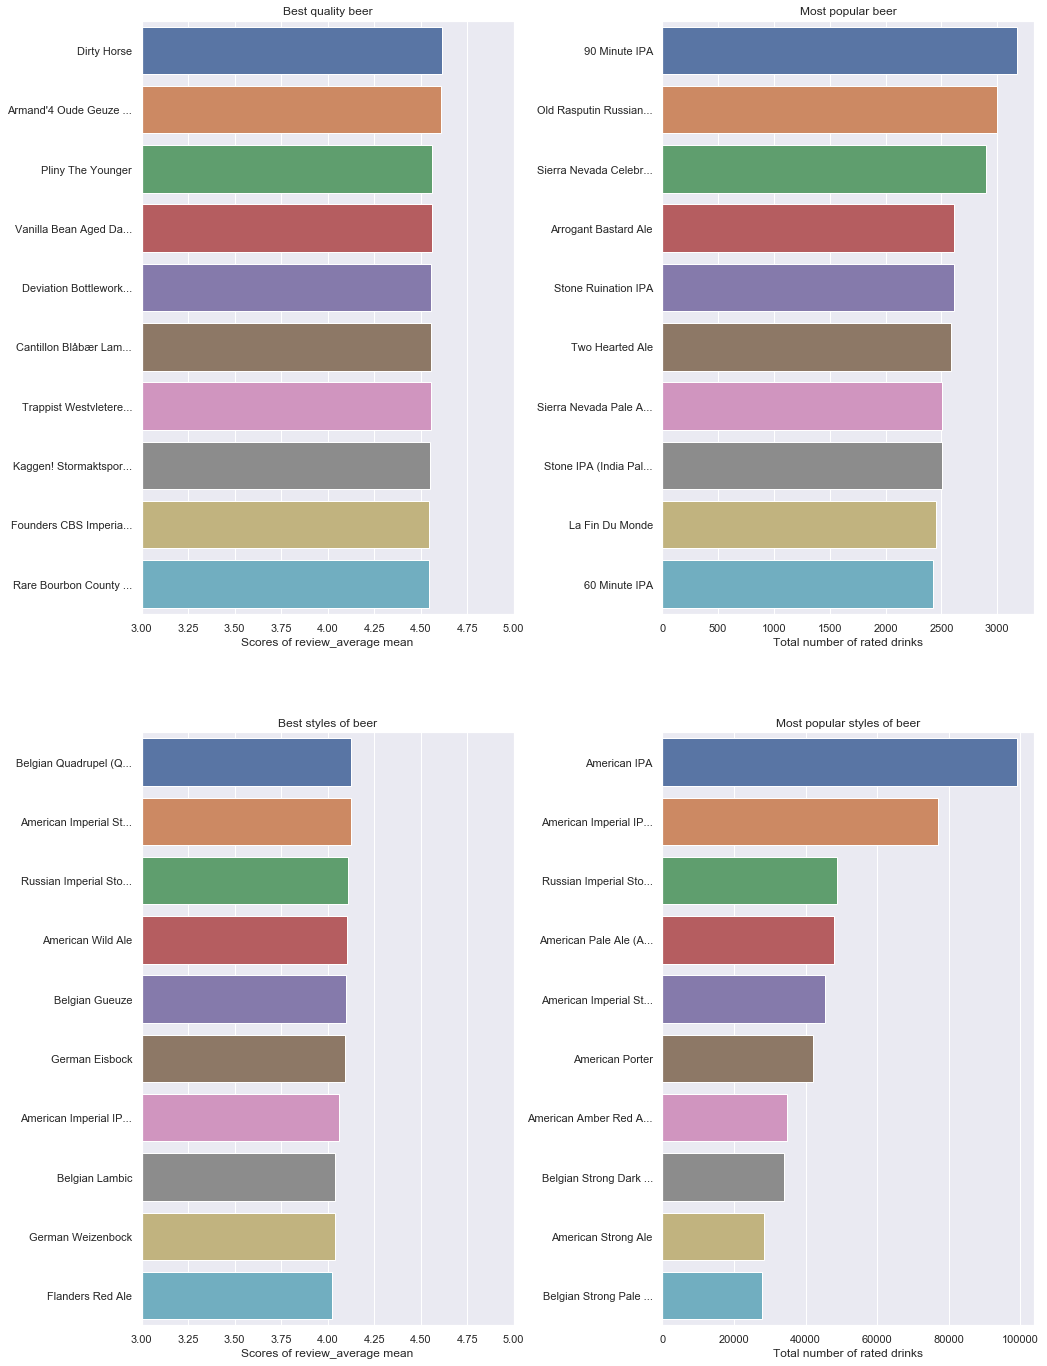

In [56]:
sns.set(rc={"axes.grid": True})
fig, subplt = plt.subplots(ncols=2, nrows=2, figsize=[16, 24])
fig.subplots_adjust(wspace=0.4)

visualize_beer_barsubplots(10, 20, \
                           beer_name_vs_ravg, beer_name_vs_count, \
                           subplt[0, 0], subplt[0, 1], \
                           "Best quality beer", "Most popular beer",
                           "Scores of review_average mean", "Total number of rated drinks")

visualize_beer_barsubplots(10, 20, \
                           beer_style_vs_ravg, beer_style_vs_count, \
                           subplt[1, 0], subplt[1, 1], \
                           "Best styles of beer", "Most popular styles of beer", \
                           "Scores of review_average mean", "Total number of rated drinks")


#### CONCLUSIONES DE LOS GRAFICOS DE BARRAS DE LOS ESTILOS DE CERVEZA

Se puede estimar que existen estilos de cerveza mas valorados y con mayor calidad segun las puntuaciones de las revisiones:

    la mayor parte de las cervezas mejor valoradas, 'American Double Imperial' pej., estan por encima de 4 de valoración y tinene casi 80000 valoraciones.

Aunque es una conclusion algo intuitiva, se confirma con este analisis que el estilo de la cerveza tambien influye en la Valoracion o posible compra de una cerveza.

Por ello, podría ser un buen candidato para incluir como un parametro posterior de filtrado u ordenacion para adaptar la recomendacion al gusto del cliente.